In [14]:
import talib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime

In [17]:
df_stockload = web.DataReader("600410.SS", "yahoo", datetime.datetime(2015,10,1), datetime.datetime(2019,4,1))
df_stockload['atr14'] = talib.ATR(df_stockload.High.values, df_stockload.Low.values, df_stockload.Close.values, timeperiod=14)
df_stockload['atr20'] = talib.ATR(df_stockload.High.values, df_stockload.Low.values, df_stockload.Close.values, timeperiod=20)


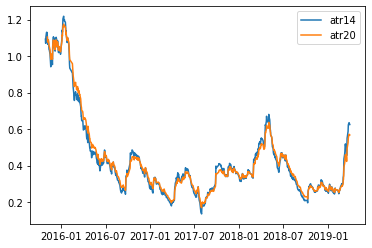

In [20]:
plt.plot(df_stockload.index,df_stockload["atr14"])
plt.plot(df_stockload.index,df_stockload["atr20"])
# plt.plot(df_stockload.index, df_stockload.Close)
plt.legend(["atr14", "atr20"], loc="best")

plt.show()

In [13]:
#股票数据获取及处理接口
def GetStockDatApi(stockName=None,stockTimeS=None,stockTimeE=None, N1=15, N2=5, n_loss=0.8, n_win=2):

    stockdata = web.DataReader(stockName, "yahoo", stockTimeS, stockTimeE)

    stockdata['N1_High'] = stockdata.High.rolling(window=N1).max()#计算最近N1个交易日最高价
    stockdata['N1_High'] = stockdata.N1_High.shift(1)
    expan_max = stockdata.Close.expanding().max()
    stockdata['N1_High'].fillna(value=expan_max,inplace=True)#目前出现过的最大值填充前N1个nan

    stockdata['N2_Low'] = stockdata.Low.rolling(window=N2).min()#计算最近N2个交易日最低价
    stockdata['N2_Low'] = stockdata.N2_Low.shift(1)
    expan_min = stockdata.Close.expanding().min()
    stockdata['N2_Low'].fillna(value=expan_min,inplace=True)#目前出现过的最小值填充前N2个nan

    stockdata['atr14'] = talib.ATR(stockdata.High.values, stockdata.Low.values, stockdata.Close.values, timeperiod=14)  # 计算ATR14
    buy_price = 0
    for kl_index, today in stockdata.iterrows():
        if today.Close > today.N1_High:
            print('N_day_buy', kl_index, today.Close)
            buy_price = today.Close
            stockdata.loc[kl_index, 'signal'] = 1
        #到达收盘价少于买入价后触发卖出
        elif (buy_price != 0) and (buy_price > today.Close) and ((buy_price - today.Close) > n_loss * today.atr14):
            print('stop_loss_n', kl_index, today.Close, buy_price)
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0
        #到达收盘价多于买入价后触发卖出
        elif (buy_price != 0) and (buy_price < today.Close) and ((today.Close - buy_price) > n_win * today.atr14):
            print('stop_win_n', kl_index, today.Close, buy_price)
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0
        elif today.Close < today.N2_Low:
            print('N_day_sell', kl_index, today.Close, buy_price)
            stockdata.loc[kl_index, 'signal'] = 0
            buy_price = 0
        else:
            pass

    stockdata['signal'].fillna(method = 'ffill',inplace = True)
    stockdata['signal'] = stockdata.signal.shift(1)
    stockdata['signal'].fillna(method = 'bfill',inplace = True)

    return stockdata